# Beverages retail sales Forecasting

**Background** 

The dataset was provided by a large beverage company in Australia. They sell their products through various supermarkets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed a forecast of each of the products (6 products in total) at item level every week in weekly buckets.

**Area of Investigation**

1. Trend
2. Seasonality
3. Serial dependence
4. Machine Learning on the time series data

## 1. Data Understanding and Preparation

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
import datetime

In [201]:
df = pd.read_csv('retail_data.csv')

In [202]:
df.shape

(1218, 12)

In [203]:
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.00000000,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.00000000,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.00000000,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.00000000,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.00000000,0,0,0,0


### 1.1 Check data types

In [204]:
df.dtypes

Product                object
date                   object
Sales                   int64
Price Discount (%)     object
In-Store Promo          int64
Catalogue Promo         int64
Store End Promo         int64
Google_Mobility       float64
Covid_Flag              int64
V_DAY                   int64
EASTER                  int64
CHRISTMAS               int64
dtype: object

In [205]:
df['date'] = pd.to_datetime(df['date'])

In [206]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)            object
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [207]:
df['Price Discount (%)'] = [x.replace('%', '') for x in df['Price Discount (%)']]
df['Price Discount (%)'] = df['Price Discount (%)'].astype('int64')

In [208]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

All data types are correct

### 1.2 Check missing values

In [209]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Product               0
date                  0
Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

No missing values were found

### 1.3 Rename the columns

In [210]:
df.columns = [c.replace(' ', '_') for c in df.columns]
df = df.rename(columns = {'In-Store_Promo' : 'In_Store_Promo'})
df.columns

Index(['Product', 'date', 'Sales', 'Price_Discount_(%)', 'In_Store_Promo',
       'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag',
       'V_DAY', 'EASTER', 'CHRISTMAS'],
      dtype='object')

### 1.4 Check for outliers

<Axes: xlabel='Sales', ylabel='Product'>

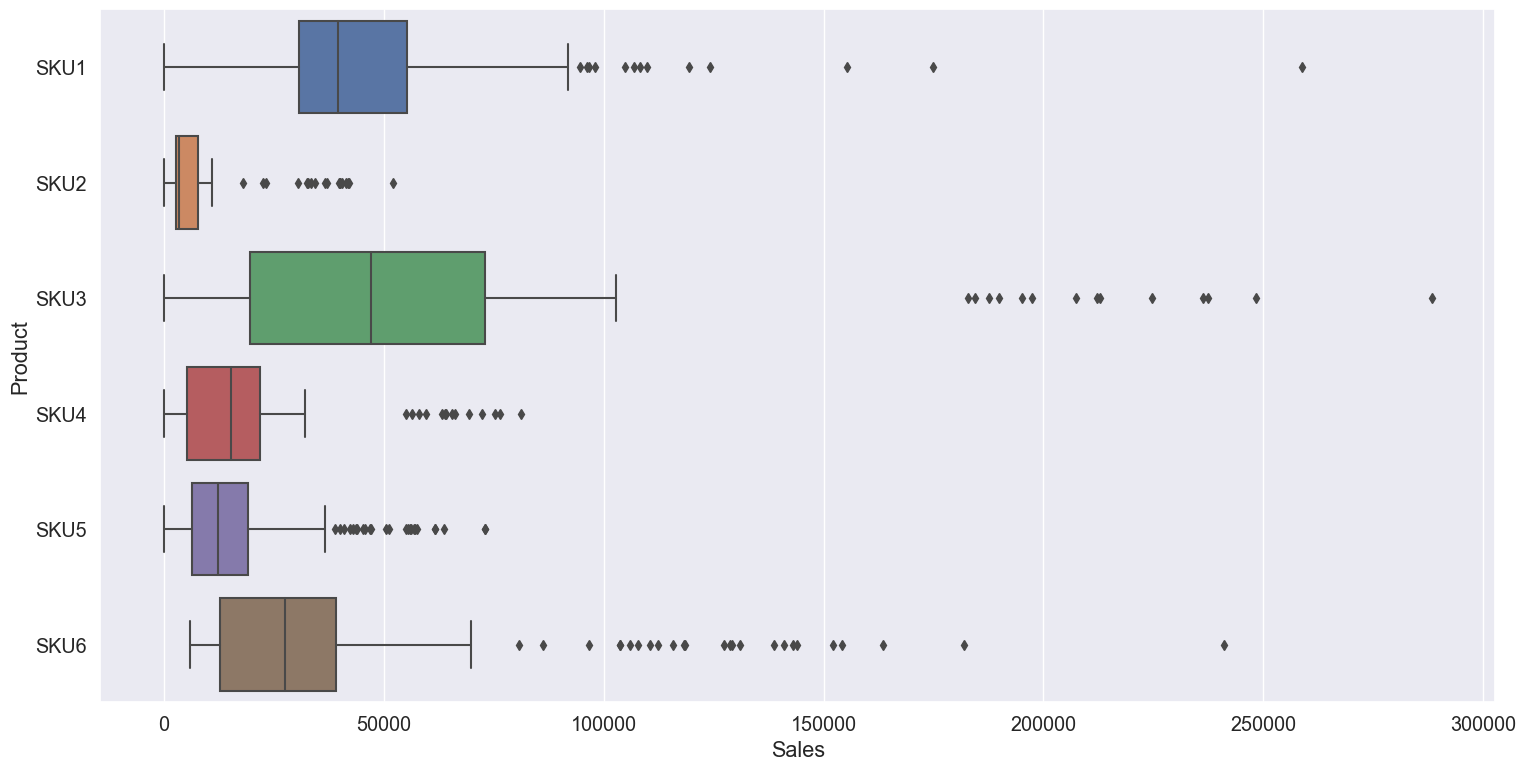

In [211]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

According to the graphs, there are products with `Sales` equals to zero. It is believed that the data needed to be predicted is mixed into the data set after checking the data.

In [212]:
# Separate the test data
df_test = df[df.Sales == 0]

It is noticed that the tested data of SKU6 is missing. 

In [213]:
# remove the 0 Sales rows
df = df.drop(df[df.Sales == 0].index)

<Axes: xlabel='Sales', ylabel='Product'>

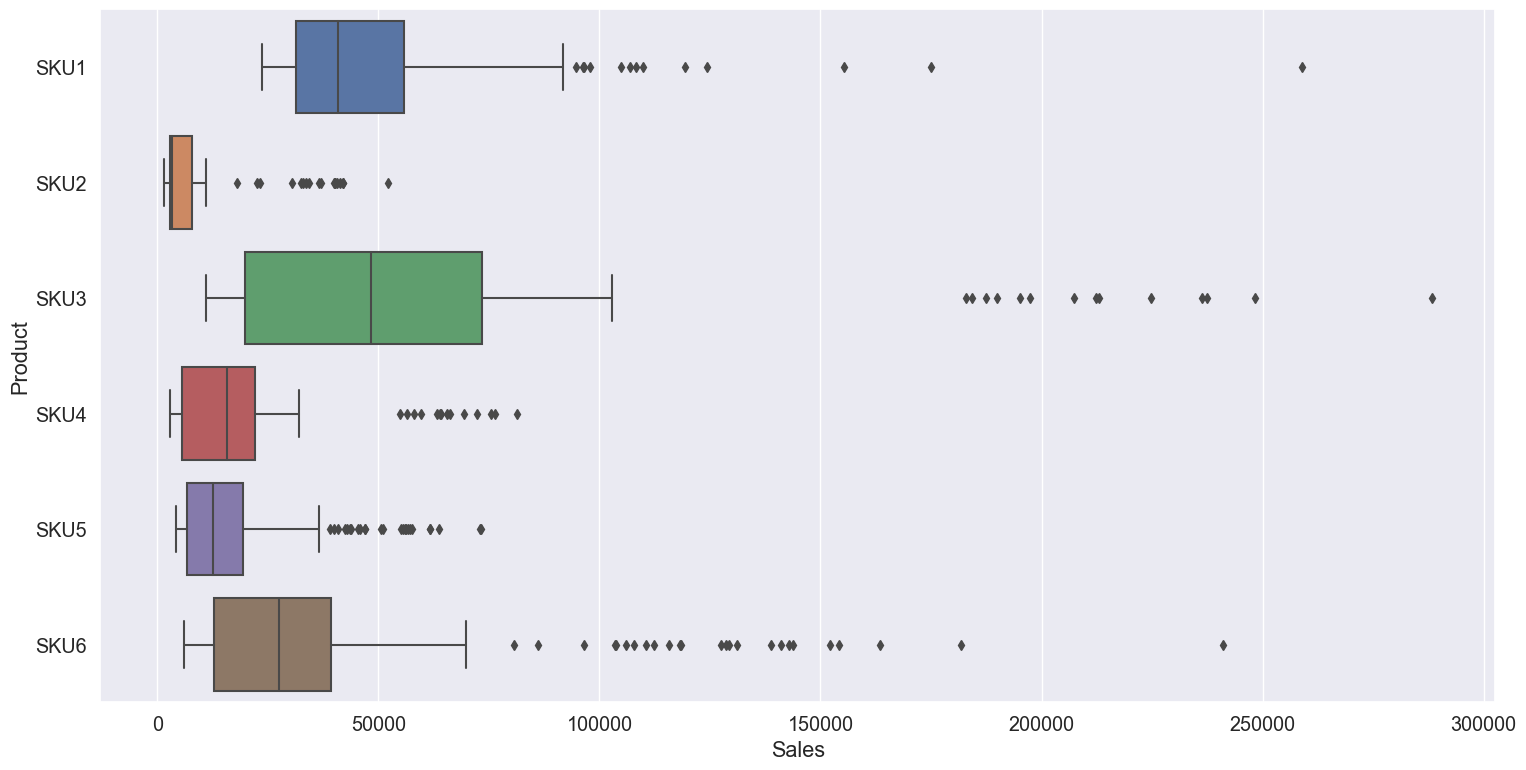

In [214]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

After removing the `Sales` equal to zero, there are still some outliers in the `Sales` feature. But since we do not have enough information on the components for the sales, it is not appropriate to treat it as an outlier.

## 2. Exploratory Data Analysis

### 2.1 Data description

In [215]:
round(df.describe(),2)

,date,Sales,Price_Discount_(%),In_Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,1188,1188.00000000,1188.00000000,1188.00000000,1188.00000000,1188.00000000,1188.00000000,1188.00000000,1188.00000000,1188.00000000,1188.00000000
mean,2018-12-26 12:00:00,31059.70000000,24.71000000,0.47000000,0.21000000,0.35000000,-2.28000000,0.21000000,0.02000000,0.02000000,0.02000000
min,2017-02-05 00:00:00,1453.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-28.49000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,2018-01-14 00:00:00,7695.25000000,2.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
50%,2018-12-26 12:00:00,20547.00000000,25.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
75%,2019-12-08 00:00:00,40978.00000000,40.00000000,1.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
max,2020-11-15 00:00:00,288322.00000000,83.00000000,1.00000000,1.00000000,1.00000000,3.90000000,1.00000000,1.00000000,1.00000000,1.00000000
std,NaN,35135.66000000,21.32000000,0.50000000,0.41000000,0.48000000,5.84000000,0.41000000,0.14000000,0.14000000,0.12000000


### 2.2 Data visualisation

In [216]:
df = df.set_index('date')

In [217]:
df['Product'].unique()

array(['SKU1', 'SKU2', 'SKU3', 'SKU4', 'SKU5', 'SKU6'], dtype=object)

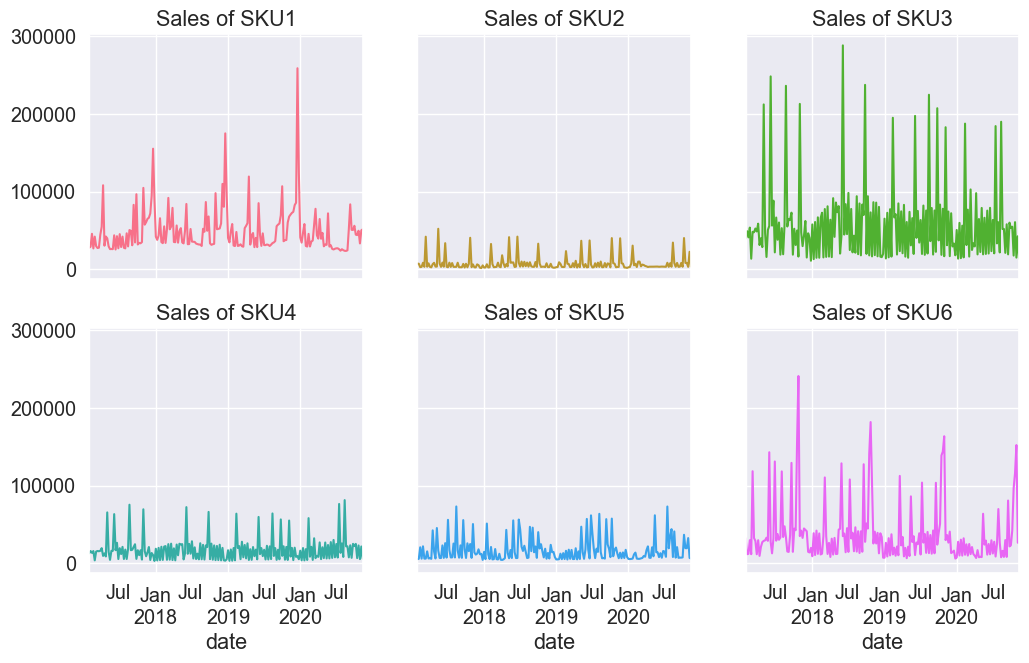

In [218]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7), sharex = True, sharey = True)
palette = sns.color_palette("husl", n_colors=df['Product'].nunique())

for i, c in enumerate(palette):
    product_name = f"SKU{str(i+1)}"
    df.query('Product == @product_name') \
        .Sales \
        .plot(ax = ax[i // 3][i % 3], color = c, title = f"Sales of {product_name}")
    


### 2.3 Correlation

In [219]:
df_corr = df.corr(numeric_only=True)
df_corr

,Sales,Price_Discount_(%),In_Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
Sales,1.00000000,0.43288693,0.25207070,-0.12439792,0.23481125,0.04488454,-0.04774825,-0.01165302,-0.01349455,-0.01389265
Price_Discount_(%),0.43288693,1.00000000,0.22542907,-0.09149157,0.23446402,-0.20749107,0.26512039,-0.04295289,0.00364036,-0.03516316
In_Store_Promo,0.25207070,0.22542907,1.00000000,-0.48872817,0.36741030,0.06047081,-0.03887343,0.02095091,0.02095091,0.02154955
Catalogue_Promo,-0.12439792,-0.09149157,-0.48872817,1.00000000,0.12477784,0.07520178,-0.09838079,-0.04546569,-0.04546569,0.03646811
Store_End_Promo,0.23481125,0.23446402,0.36741030,0.12477784,1.00000000,0.08250112,-0.06766677,0.01948886,-0.06821100,0.00961972
Google_Mobility,0.04488454,-0.20749107,0.06047081,0.07520178,0.08250112,1.00000000,-0.76437580,0.07639164,-0.11186864,0.04844984
Covid_Flag,-0.04774825,0.26512039,-0.03887343,-0.09838079,-0.06766677,-0.76437580,1.00000000,0.01521270,0.01521270,-0.06338484
V_DAY,-0.01165302,-0.04295289,0.02095091,-0.04546569,0.01948886,0.07639164,0.01521270,1.00000000,-0.02061856,-0.01781035
EASTER,-0.01349455,0.00364036,0.02095091,-0.04546569,-0.06821100,-0.11186864,0.01521270,-0.02061856,1.00000000,-0.01781035
CHRISTMAS,-0.01389265,-0.03516316,0.02154955,0.03646811,0.00961972,0.04844984,-0.06338484,-0.01781035,-0.01781035,1.00000000


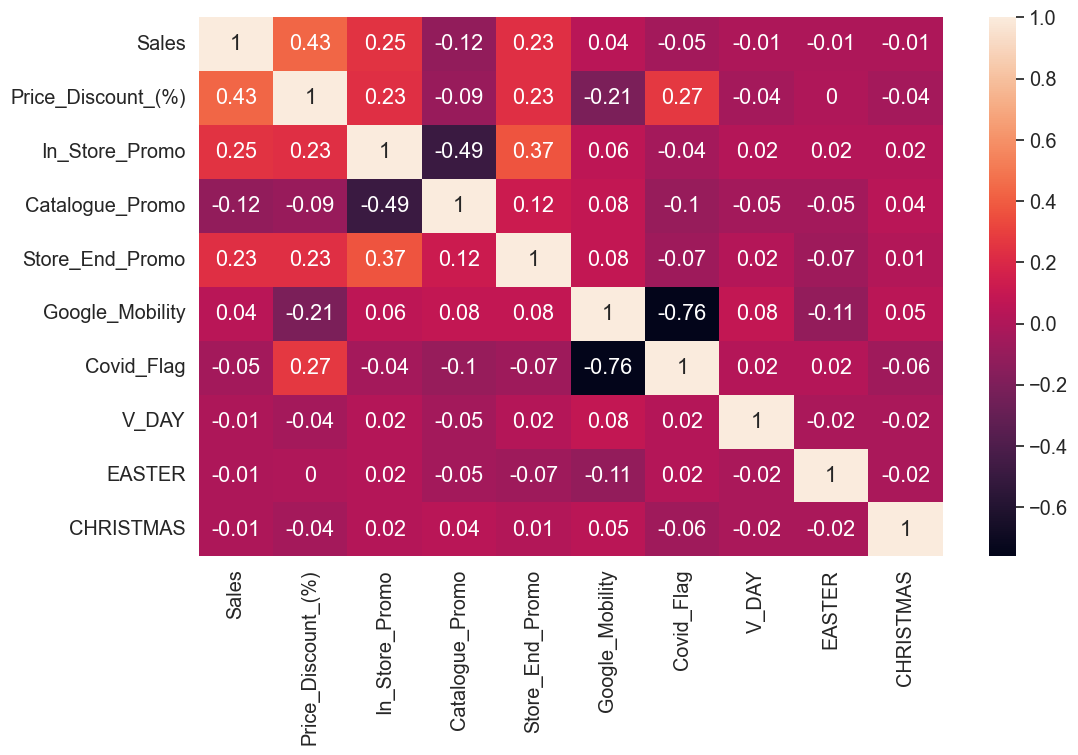

In [220]:
fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(data = round(df_corr, 2),
           annot =True)

From the heatmap, we see that `Google_Mobility` has an inverse correlation with `Covid_Flag`. `In_Store_Promo` is slightly correlated with `Catalogue_Promo` and also for `Sales` and `Price_Discount_(%)`. 

### 2.4 Seasonal Decomposition


In [221]:
# Split the 6 SKUs to different dataset
df_group = df.reset_index().groupby('Product')

# save them in dictionary
skus = {'sku1' : df_group.get_group("SKU1").set_index('date'),
    'sku2' : df_group.get_group("SKU2").set_index('date'),
    'sku3' : df_group.get_group("SKU3").set_index('date'),
    'sku4' : df_group.get_group("SKU4").set_index('date'),
    'sku5' : df_group.get_group("SKU5").set_index('date'),
    'sku6' : df_group.get_group("SKU6").set_index('date')}


In [222]:
# graphs to show seasonal_decompose
def seasonal_decompose (y, title):
    y = y.rename(title + " Sales")
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

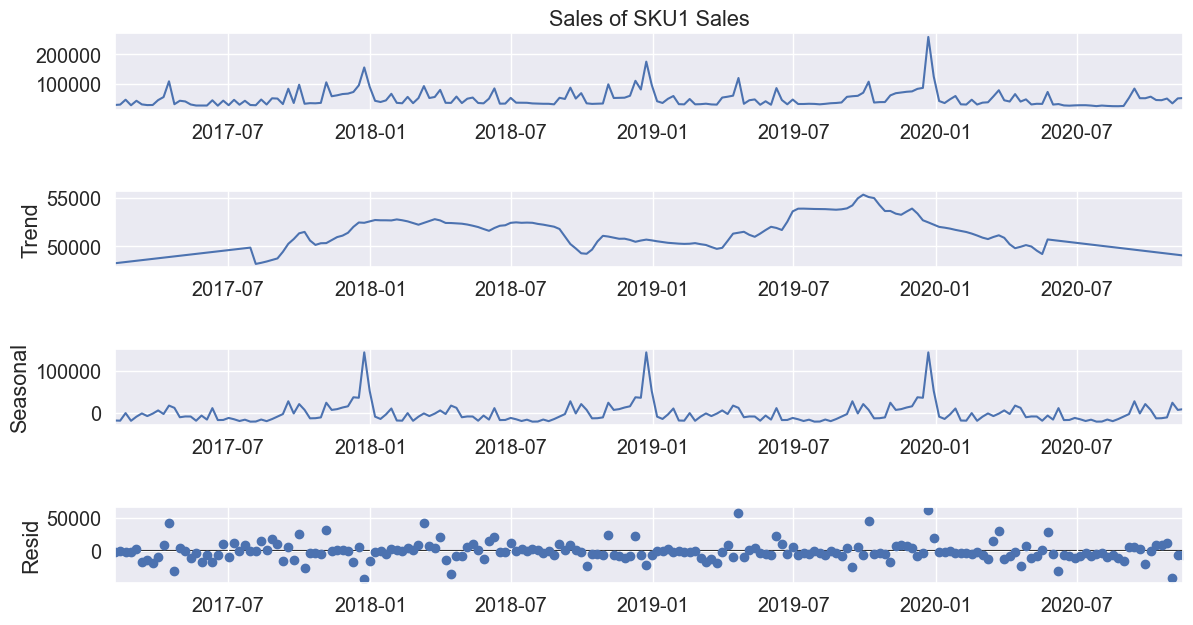

In [223]:
# SKU1
seasonal_decompose(skus['sku1'].Sales, "Sales of SKU1")

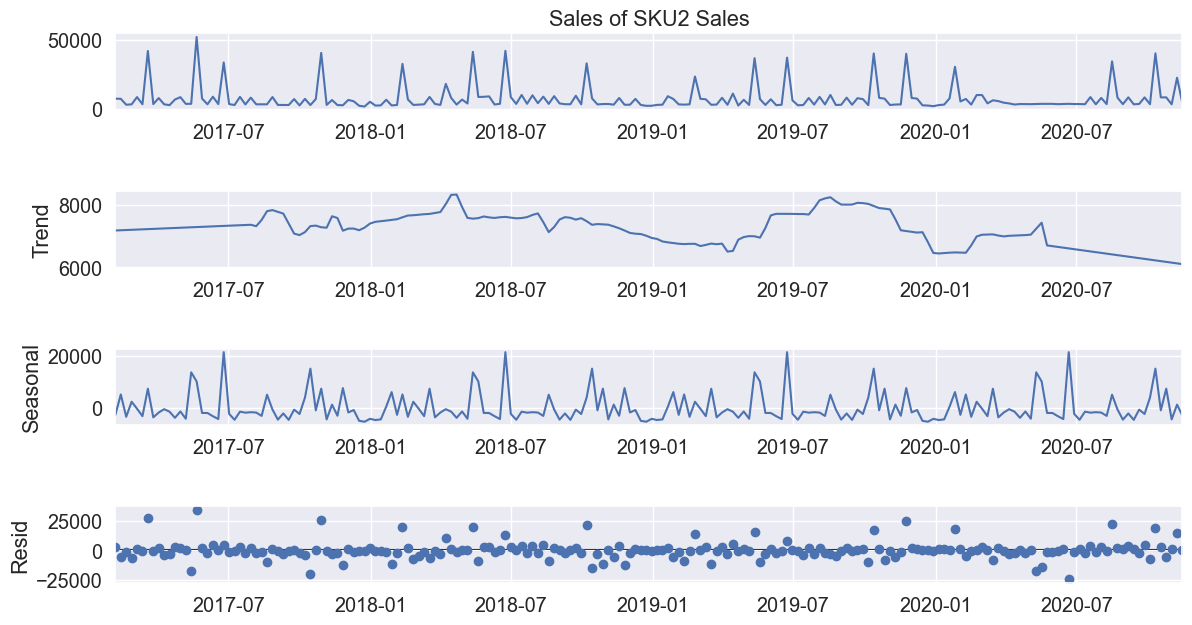

In [224]:
# SKU2
seasonal_decompose(skus['sku2'].Sales, "Sales of SKU2")

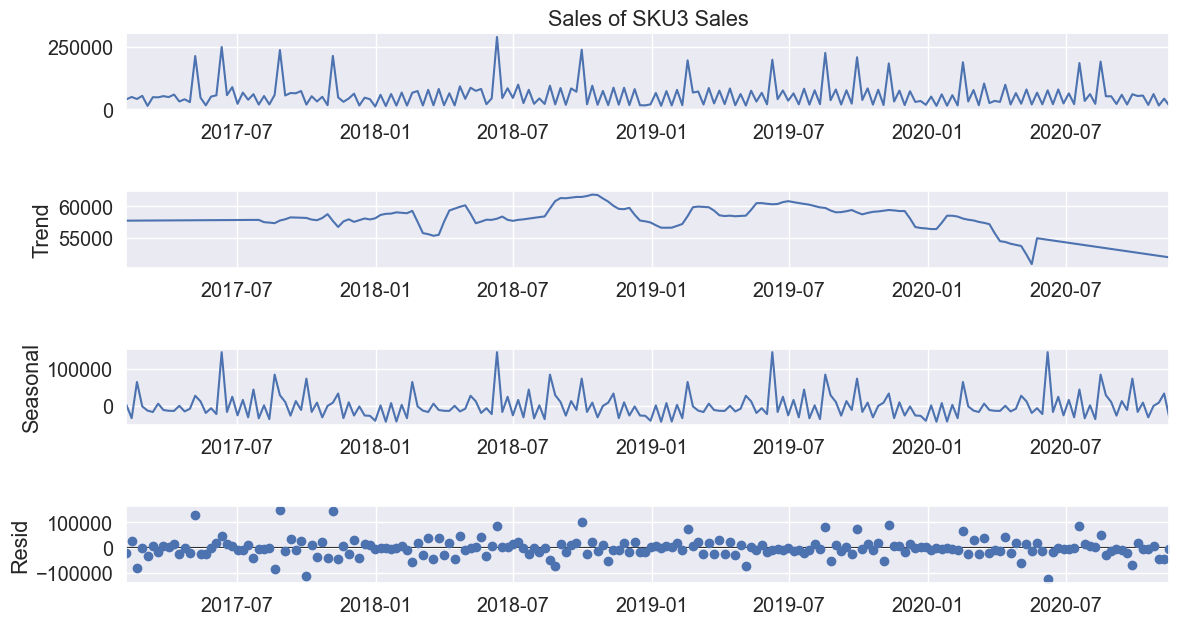

In [225]:
# SKU3
seasonal_decompose(skus['sku3'].Sales, "Sales of SKU3")

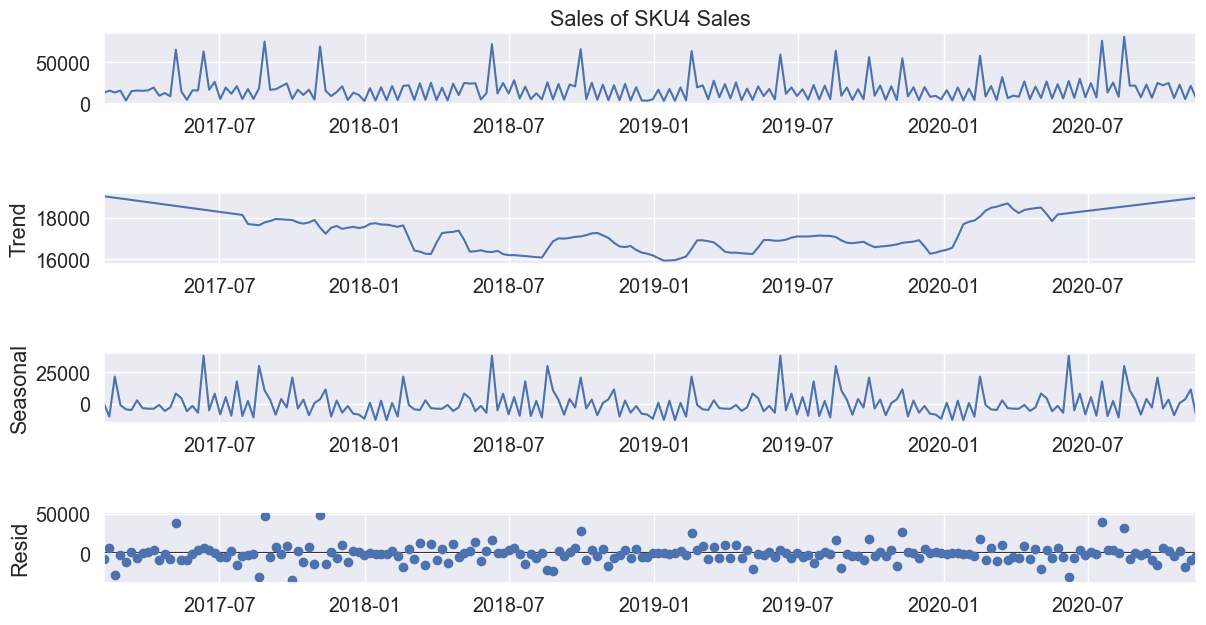

In [226]:
# SKU4
seasonal_decompose(skus['sku4'].Sales, "Sales of SKU4")

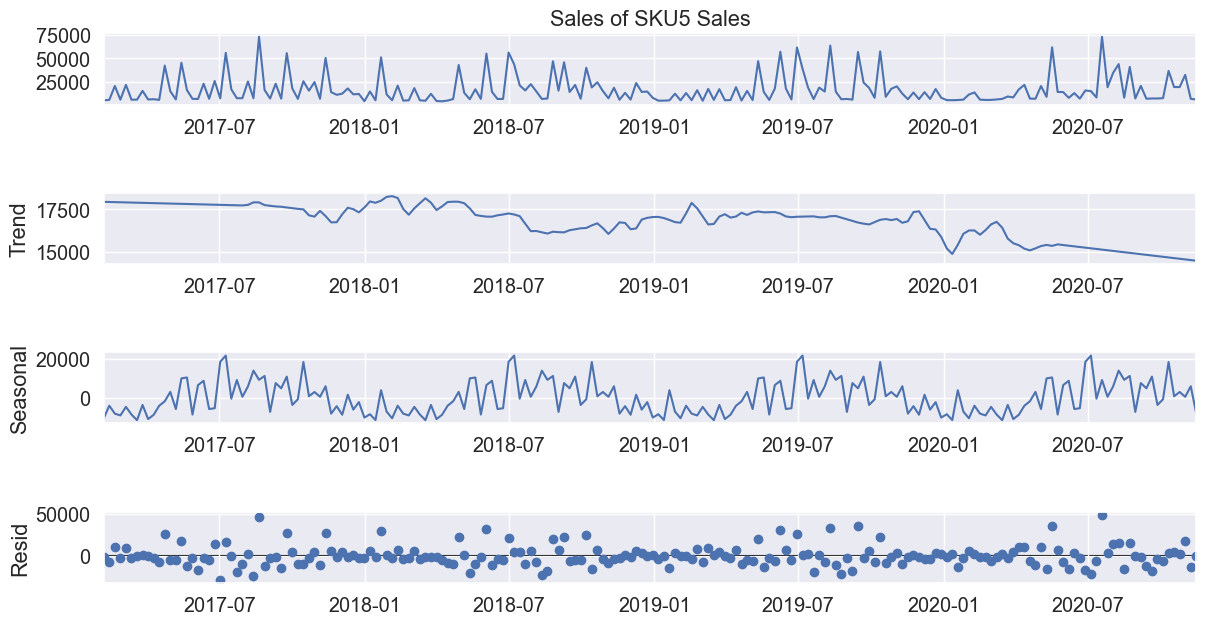

In [227]:
# SKU5
seasonal_decompose(skus['sku5'].Sales, "Sales of SKU5")

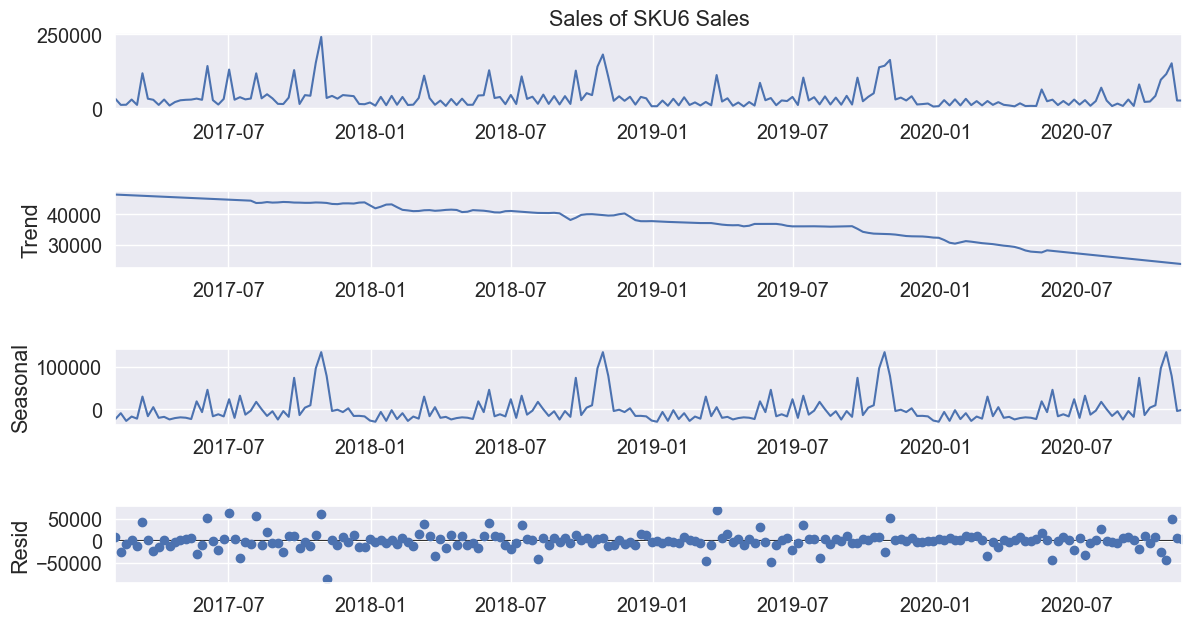

In [228]:
# SKU6
seasonal_decompose(skus['sku6'].Sales, "Sales of SKU6")

### 2.5 Stationarity

In [229]:
# plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    ax.legend()

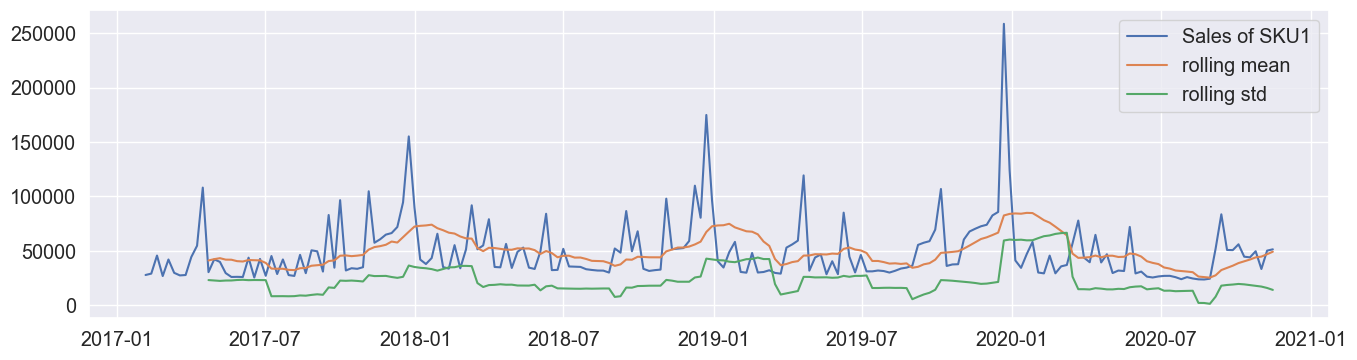

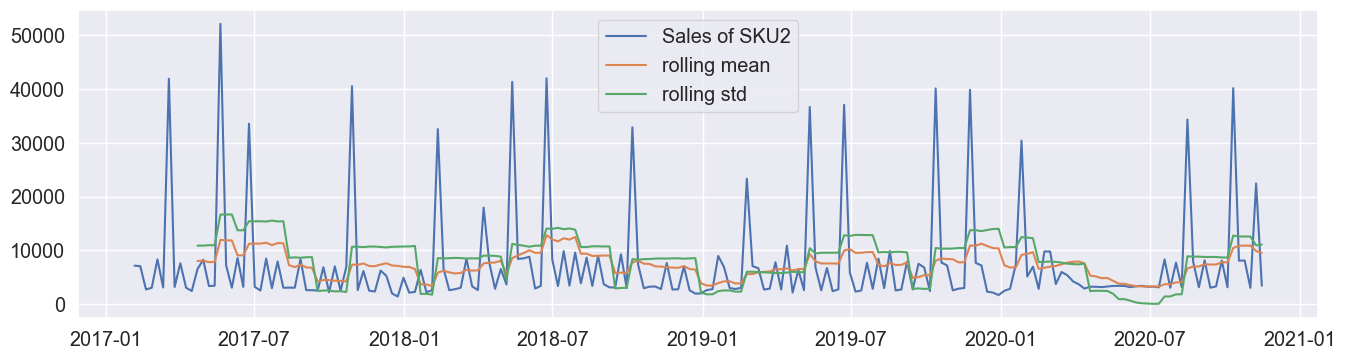

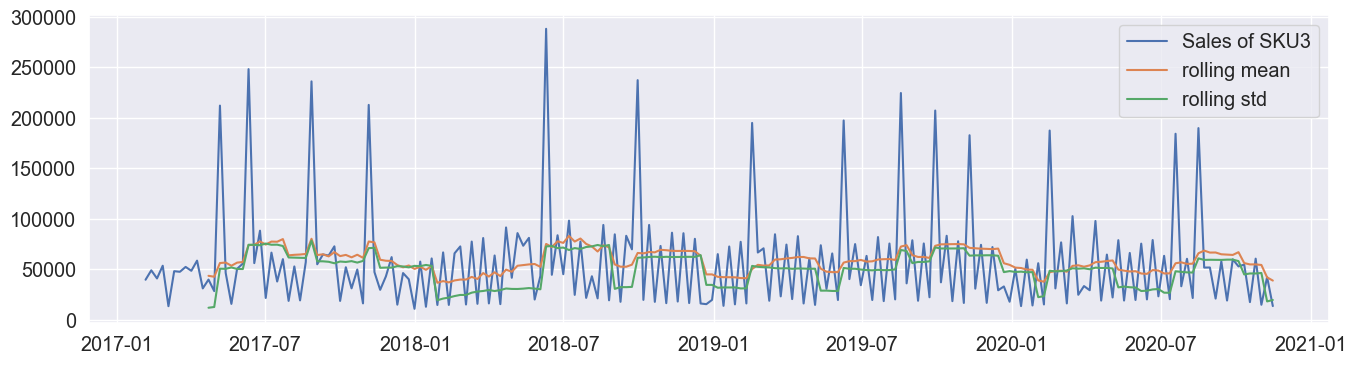

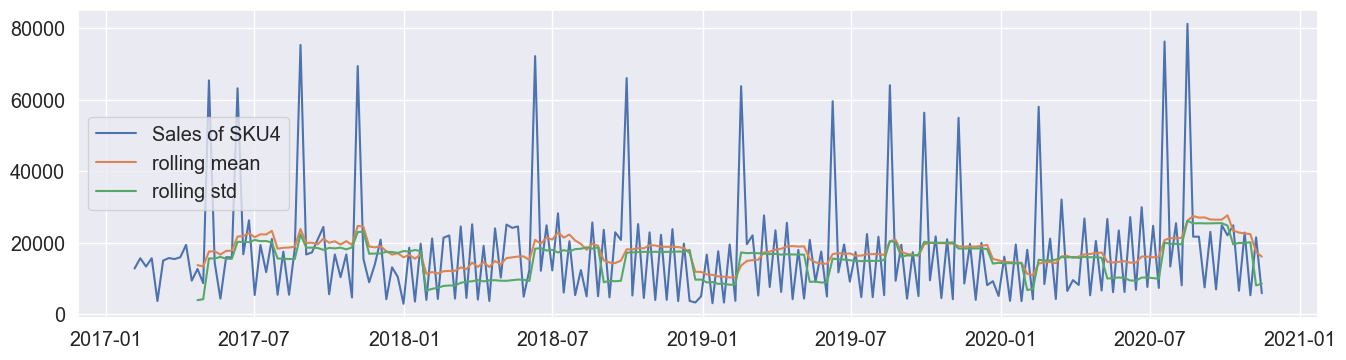

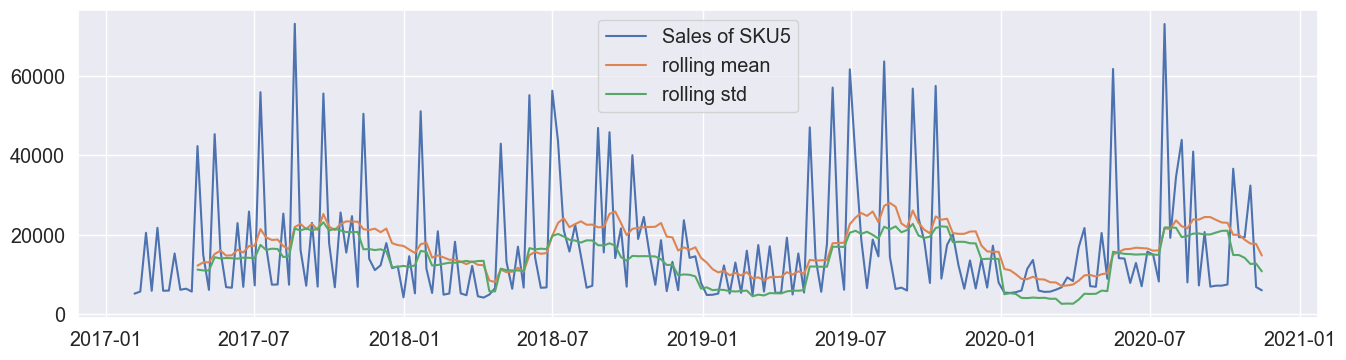

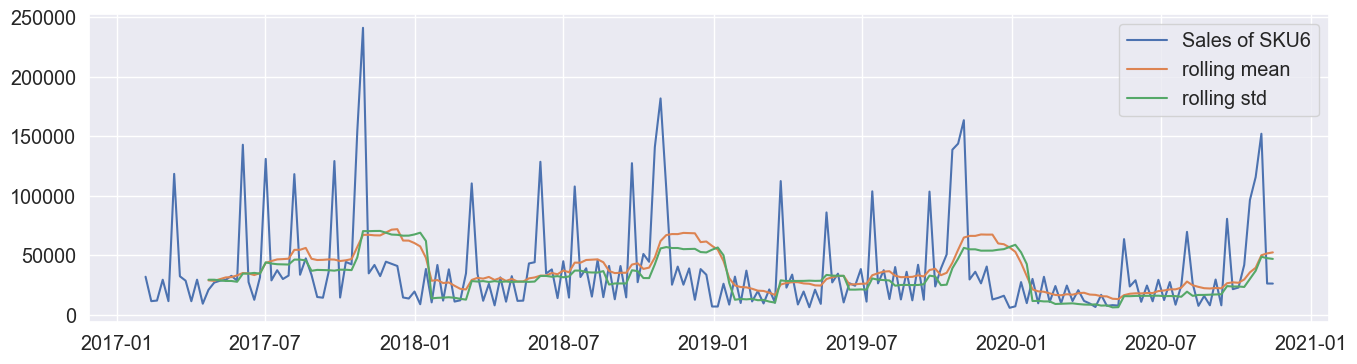

In [230]:
pd.options.display.float_format = '{:.8f}'.format
for key, sku in skus.items():
    test_stationarity(sku.Sales, "Sales of " + key.upper() )

In [231]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [232]:
for key, sku in skus.items():
    ADF_test(sku.Sales, "Sales of " + key.upper())

 > Is the Sales of SKU1 stationary ?
Test statistic = -9.083
P-value = 0.000
Critical values :
	1%: -3.463987334463603 - The data is  stationary with 99% confidence
	5%: -2.8763259091636213 - The data is  stationary with 95% confidence
	10%: -2.5746515171738515 - The data is  stationary with 90% confidence
 > Is the Sales of SKU2 stationary ?
Test statistic = -15.166
P-value = 0.000
Critical values :
	1%: -3.463987334463603 - The data is  stationary with 99% confidence
	5%: -2.8763259091636213 - The data is  stationary with 95% confidence
	10%: -2.5746515171738515 - The data is  stationary with 90% confidence
 > Is the Sales of SKU3 stationary ?
Test statistic = -3.145
P-value = 0.023
Critical values :
	1%: -3.4668001583460613 - The data is not stationary with 99% confidence
	5%: -2.8775552336674317 - The data is  stationary with 95% confidence
	10%: -2.5753075498128246 - The data is  stationary with 90% confidence
 > Is the Sales of SKU4 stationary ?
Test statistic = -6.287
P-value = 

From the Dickey Fuller test, we know that the Sales data at for all 6 SKUs are stationary.

### 2.6 Periodogram

In [233]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("52W") / pd.Timedelta("1W")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

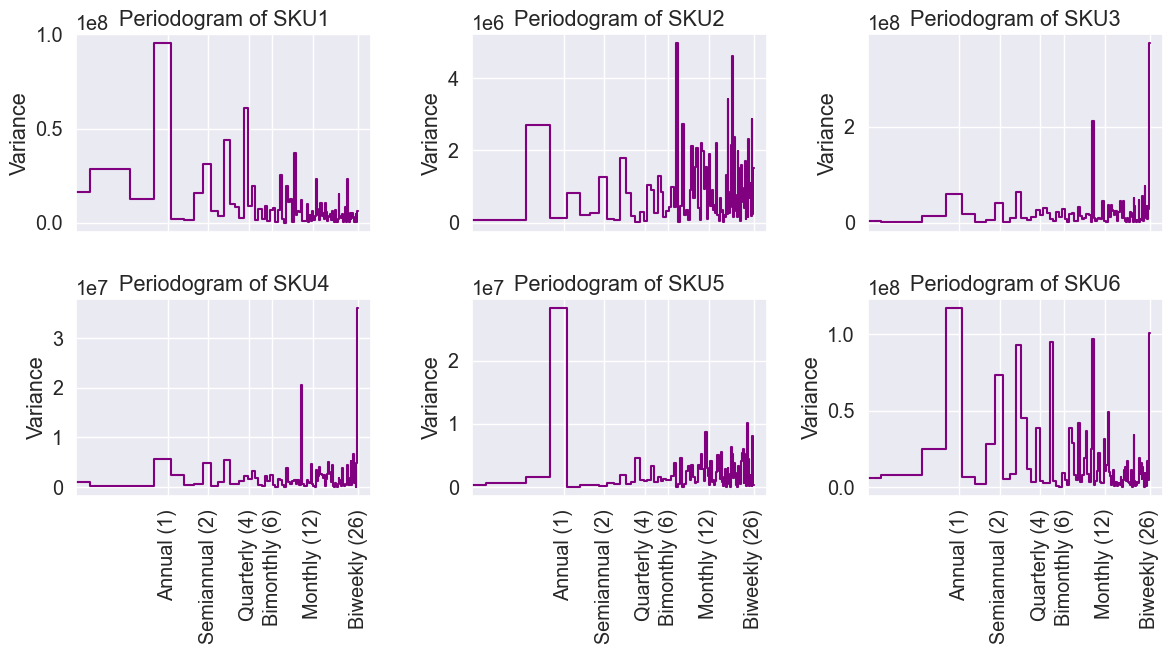

In [234]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7), sharex = True)
for i, (key, sku) in enumerate(skus.items()):
    plot_periodogram(sku.Sales, ax = ax[i//3][i%3])
    ax[i//3][i%3].set_title(f"Periodogram of {key.upper()}")
    
fig.tight_layout()

# 3. Features engineering

### 3.1 Train test split

In [152]:
train_skus = {}
val_skus = {}

from sklearn.model_selection import train_test_split

for key, sku in skus.items():
    trainX_key = key + '_X_train'
    valX_key = key + '_X_val'
    trainy_key = key + '_y_train'
    valy_key = key + '_y_val'
    
    y = sku.Sales
    X = sku.drop(['Sales'], axis = 1)
    
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    train_skus[trainX_key] = X_train
    train_skus[trainy_key] = y_train
    val_skus[valX_key] = X_val
    val_skus[valy_key] = y_val
    
    
    

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess



## 4. Model training

### 4.1 splitting the dataset

In [101]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini
                                                                                       , mini))

In [102]:
sarima_grid_search(sku1.Sales,52)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:2091.3985709441963


In [103]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [104]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2019-06-02',y_to_val)

NameError: name 'y_to_val' is not defined

In [106]:
sku1

,Product,Sales,Price_Discount_(%),In_Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,,
2017-02-05,SKU1,27750,0,0,0,0,0.00000000,0,0,0,0
2017-02-12,SKU1,29023,0,1,0,1,0.00000000,0,1,0,0
2017-02-19,SKU1,45630,17,0,0,0,0.00000000,0,0,0,0
2017-02-26,SKU1,26789,0,1,0,1,0.00000000,0,0,0,0
2017-03-05,SKU1,41999,17,0,0,0,0.00000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-18,SKU1,43976,17,1,0,0,-7.56000000,1,0,0,0
2020-10-25,SKU1,49593,17,0,0,0,-8.39000000,1,0,0,0
2020-11-01,SKU1,33267,1,1,0,1,-7.43000000,1,0,0,0


In [182]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=sku1.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_sku1 = dp.in_sample()

In [176]:
X.columns

Index(['const', 'trend', 's(2,52)', 's(3,52)', 's(4,52)', 's(5,52)', 's(6,52)',
       's(7,52)', 's(8,52)', 's(9,52)', 's(10,52)', 's(11,52)', 's(12,52)',
       's(13,52)', 's(14,52)', 's(15,52)', 's(16,52)', 's(17,52)', 's(18,52)',
       's(19,52)', 's(20,52)', 's(21,52)', 's(22,52)', 's(23,52)', 's(24,52)',
       's(25,52)', 's(26,52)', 's(27,52)', 's(28,52)', 's(29,52)', 's(30,52)',
       's(31,52)', 's(32,52)', 's(33,52)', 's(34,52)', 's(35,52)', 's(36,52)',
       's(37,52)', 's(38,52)', 's(39,52)', 's(40,52)', 's(41,52)', 's(42,52)',
       's(43,52)', 's(44,52)', 's(45,52)', 's(46,52)', 's(47,52)', 's(48,52)',
       's(49,52)', 's(50,52)', 's(51,52)', 's(52,52)', 'sin(1,freq=A-DEC)',
       'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)',
       'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)', 'sin(4,freq=A-DEC)',
       'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)', 'cos(5,freq=A-DEC)',
       'sin(6,freq=A-DEC)', 'cos(6,freq=A-DEC)', 'sin(7,freq=A-DEC)',
       'cos(7,

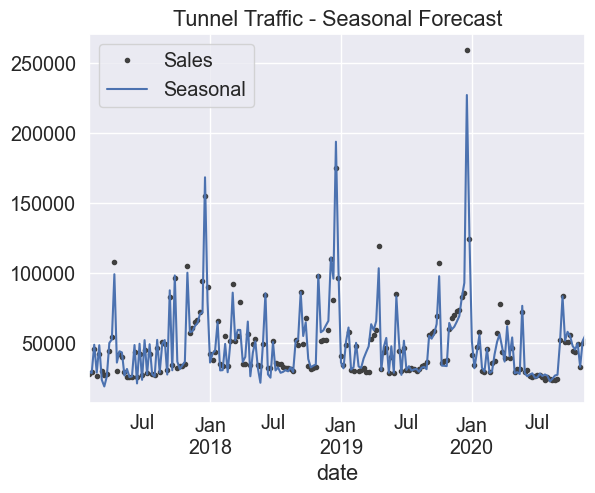

In [185]:
y = sku1["Sales"]
d = pd.date_range('2020-11-14', periods=289, freq='7D')


# d = [
#     datetime.datetime(2020, 11, 14),
#      datetime.datetime(2020, 11, 22), datetime.datetime(2020, 11, 29),
#      datetime.datetime(2020, 12, 6), datetime.datetime(2020, 12, 13),
#     datetime.datetime(2020, 12, 20), datetime.datetime(2020, 12, 27)]

X = pd.merge(sku1.drop(['Sales', 'Product'], axis= 1), X_sku1, left_index=True, right_index = True)
# X = X_sku1
y_train = y[:-30]
y_test = y[-30:]
X_train = X[:-30]
X_test = X[-30:]

# X.head()
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
# X_fore = dp.out_of_sample(steps=len(d), forecast_index =d)
# y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
# ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [118]:
dp.out_of_sample.__doc__

'\nProduce deterministic trends for out-of-sample forecasts\n\nParameters\n----------\nsteps : int\n    The number of steps to forecast\nindex : index_like\n    An index-like object. If not an index, it is converted to an\n    index.\nforecast_index : index_like\n    An Index or index-like object to use for the forecasts. If\n    provided must have steps elements.\n\nReturns\n-------\nDataFrame\n    A DataFrame containing the deterministic terms.\n'

In [171]:
times = pd.date_range('2012-10-01', periods=289, freq='7D')

In [173]:
import numpy as np

np.array(times)

array(['2012-10-01T00:00:00.000000000', '2012-10-08T00:00:00.000000000',
       '2012-10-15T00:00:00.000000000', '2012-10-22T00:00:00.000000000',
       '2012-10-29T00:00:00.000000000', '2012-11-05T00:00:00.000000000',
       '2012-11-12T00:00:00.000000000', '2012-11-19T00:00:00.000000000',
       '2012-11-26T00:00:00.000000000', '2012-12-03T00:00:00.000000000',
       '2012-12-10T00:00:00.000000000', '2012-12-17T00:00:00.000000000',
       '2012-12-24T00:00:00.000000000', '2012-12-31T00:00:00.000000000',
       '2013-01-07T00:00:00.000000000', '2013-01-14T00:00:00.000000000',
       '2013-01-21T00:00:00.000000000', '2013-01-28T00:00:00.000000000',
       '2013-02-04T00:00:00.000000000', '2013-02-11T00:00:00.000000000',
       '2013-02-18T00:00:00.000000000', '2013-02-25T00:00:00.000000000',
       '2013-03-04T00:00:00.000000000', '2013-03-11T00:00:00.000000000',
       '2013-03-18T00:00:00.000000000', '2013-03-25T00:00:00.000000000',
       '2013-04-01T00:00:00.000000000', '2013-04-08